Epoch 1/20 | Train Loss: 0.1229 | Validation Loss: 0.0652
Epoch 6/20 | Train Loss: 0.0207 | Validation Loss: 0.0264
Epoch 11/20 | Train Loss: 0.0235 | Validation Loss: 0.0219
Epoch 16/20 | Train Loss: 0.0190 | Validation Loss: 0.0264
Epoch 20/20 | Train Loss: 0.0132 | Validation Loss: 0.0119
Epoch 1/20 | Train Loss: 0.1510 | Validation Loss: 0.1075
Epoch 6/20 | Train Loss: 0.0848 | Validation Loss: 0.0712
Epoch 11/20 | Train Loss: 0.0238 | Validation Loss: 0.0273
Epoch 16/20 | Train Loss: 0.0162 | Validation Loss: 0.0146
Epoch 20/20 | Train Loss: 0.0130 | Validation Loss: 0.0116
Epoch 1/50 | Train Loss: 0.1247 | Validation Loss: 0.0353
Epoch 6/50 | Train Loss: 0.0185 | Validation Loss: 0.0142
Epoch 11/50 | Train Loss: 0.0156 | Validation Loss: 0.0164
Epoch 16/50 | Train Loss: 0.0222 | Validation Loss: 0.0192
Epoch 21/50 | Train Loss: 0.0180 | Validation Loss: 0.0217
Epoch 26/50 | Train Loss: 0.0182 | Validation Loss: 0.0232
Epoch 31/50 | Train Loss: 0.0266 | Validation Loss: 0.0148
Epo

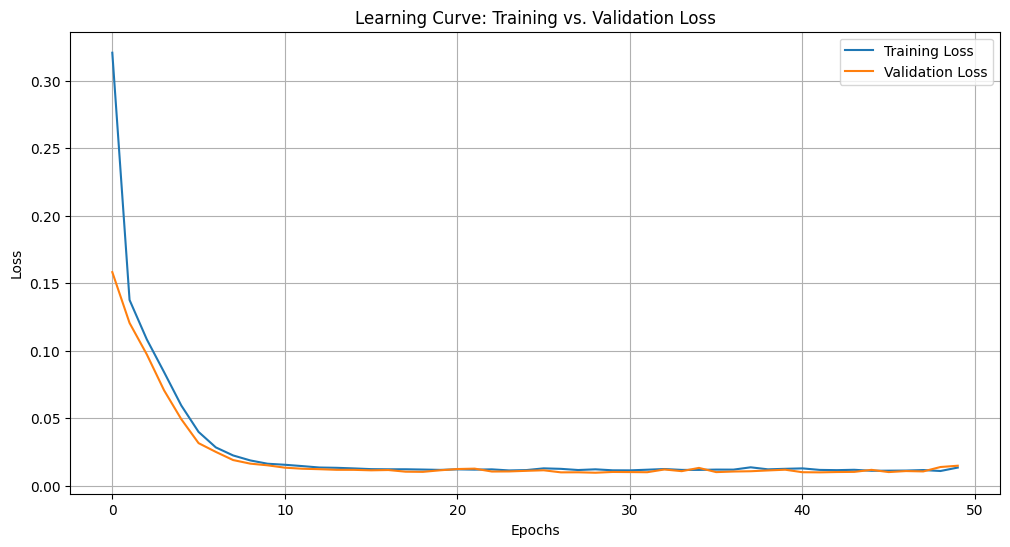

Predicted y for x = 3.0: 0.2009
Actual y for x = 3.0: 0.1411
Error: 0.0598


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset, DataLoader
from sklearn.model_selection import ParameterGrid

x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x) + torch.randn(x.size()) / 10
y = y.view(-1, 1)

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_set, val_set, test_set = random_split(CustomDataset(x, y), [1000, 500, 500])

class PolynomialCurveFitting(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 9)
        self.fc3 = nn.Linear(9, 1)

    def forward(self, x):
        x = x.view(-1, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

param_grid = {
    'alpha': [0.1, 0.01],
    'batch_size': [32, 64],
    'epochs': [20, 50],
    'optim': [optim.Adam, optim.SGD]
}

val_loader = DataLoader(val_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

best_val_loss = float('inf')
best_params = None
best_train_losses = []
best_val_losses = []

for params in ParameterGrid(param_grid):
    train_loader = DataLoader(train_set, batch_size=params['batch_size'], shuffle=True)
    model = PolynomialCurveFitting()
    optimizer = params['optim'](model.parameters(), lr=params['alpha'])
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(params['epochs']):
        model.train()
        epoch_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss = epoch_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_loader):
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)


        if epoch % 5 == 0 or epoch == params['epochs'] - 1:
            print(f"Epoch {epoch + 1}/{params['epochs']} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_train_losses = train_losses
            best_val_losses = val_losses
            best_model = model

print("Best Parameters:", best_params)
print("Best Validation Loss:", best_val_loss)

avg_test_loss = 0.0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        outputs = best_model(inputs)  # Use best model here
        loss = criterion(outputs, targets)
        avg_test_loss += loss.item()

avg_test_loss /= len(test_loader)
print("Average Test Loss:", avg_test_loss)

plt.figure(figsize=(12, 6))
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.title('Learning Curve: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

def predict(model, x):
    model.eval()
    with torch.no_grad():
        return model(torch.tensor([[x]]))

x_input = 3.0
predicted_y = predict(best_model, x_input)  # Use best model here
print(f"Predicted y for x = {x_input}: {predicted_y.item():.4f}")

actual_y = math.sin(x_input)
print(f"Actual y for x = {x_input}: {actual_y:.4f}")

error = abs(predicted_y.item() - actual_y)
print(f"Error: {error:.4f}")
